
## **PROJET DE TRAITEMENT D'IMAGE**

# **Ecrire un nouveau script permettant :**

# 1.   d’ouvrir et afficher une image de la séquence (on utilisera tout d’abord l’image Code0.png)



In [79]:
#Importation des bibliothèques nécessaires au cours du développement
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder


# Lire l'image
image = cv2.imread('code0.tif')

# Afficher l'image en couleur
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Image en couleur')
plt.show()




# 2.   transformer l’image couleur acquise en image monochrome si nécessaire et d’afficher cette image

Une image monochrome est une image en niveaux de gris où chaque pixel a une valeur représentant une intensité lumineuse. Cela va de 0 (noir) à 255 (blanc) pour une image 8 bits.





In [80]:
# Convertir l'image en niveaux de gris
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Afficher l'image en niveaux de gris
plt.imshow(gray_image, cmap='gray')
plt.title('Image en niveaux de gris')
plt.show()




# 3.   Calculer et d’afficher l’histogramme de l’image monochrome


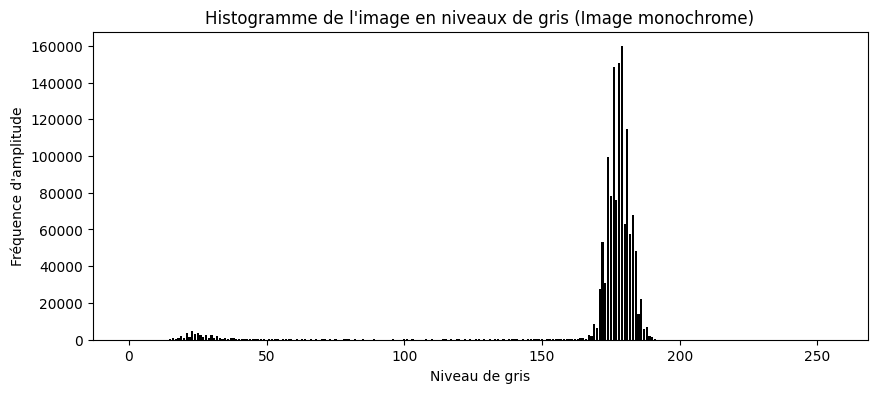

In [81]:
# 3. Calculer et afficher l'histogramme de l'image monochrome

# Calculer l'histogramme
histogram = cv2.calcHist([gray_image], [0], None, [256], [0,256])

# Afficher l'histogramme
plt.figure(figsize=(10, 4))
plt.bar(range(256), histogram[:,0], color='black')
plt.title('Histogramme de l\'image en niveaux de gris (Image monochrome)')
plt.xlabel('Niveau de gris')
plt.ylabel('Fréquence d\'amplitude')
plt.show()




# 4.   binariser cette image de telle sorte à obtenir les chiffres en blanc et un fond en noir. Si plusieurs




In [82]:
# Appliquer la binarisation (le fond sera noir et les chiffres blancs)
_, binary_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY_INV)

# Afficher l'image binarisée
plt.figure(figsize=(6, 6))
plt.imshow(binary_image, cmap='gray')
plt.title('Image binarisée')
plt.axis('off')
plt.show()


# **Localisation des chiffres du code postal**



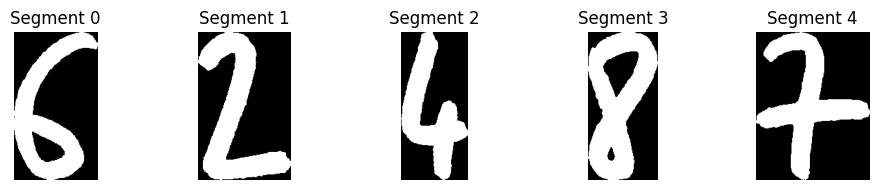

In [83]:
# Convertir l'image binarisée en objet PIL pour la segmentation
binary_image_pil = Image.fromarray(binary_image)

def segment_image(binary_image):
    width, height = binary_image.size
    pixels = binary_image.load()

    segments = []
    start = None

    for x in range(width):
        column_has_foreground = False
        for y in range(height):
            if pixels[x, y] == 255:  # si le pixel est blanc (chiffre)
                column_has_foreground = True
                break

        if column_has_foreground and start is None:
            start = x
        elif not column_has_foreground and start is not None:
            segments.append((start, x))
            start = None

    if start is not None:
        segments.append((start, width))

    return segments

def trim_segment(segment):
    width, height = segment.size
    pixels = segment.load()

    top, bottom, left, right = height, 0, width, 0

    for y in range(height):
        for x in range(width):
            if pixels[x, y] == 255:  # si le pixel est blanc (chiffre)
                if y < top:
                    top = y
                if y > bottom:
                    bottom = y
                if x < left:
                    left = x
                if x > right:
                    right = x

    return segment.crop((left, top, right+1, bottom+1))

def save_segments(image, segments, output_prefix='segment'):
    plt.figure(figsize=(len(segments) * 2, 2))

    for i, (start, end) in enumerate(segments):
        segment = image.crop((start, 0, end, image.height))
        trimmed_segment = trim_segment(segment)

        plt.subplot(1, len(segments), i + 1)
        plt.imshow(trimmed_segment, cmap='gray')
        plt.title(f"Segment {i}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def main():
    image_path = 'code0.tif'
    image = Image.fromarray(binary_image)

    segments = segment_image(binary_image_pil)
    save_segments(image, segments)

if __name__ == "__main__":
    main()


# **Extraction des caractéristiques des chiffres**

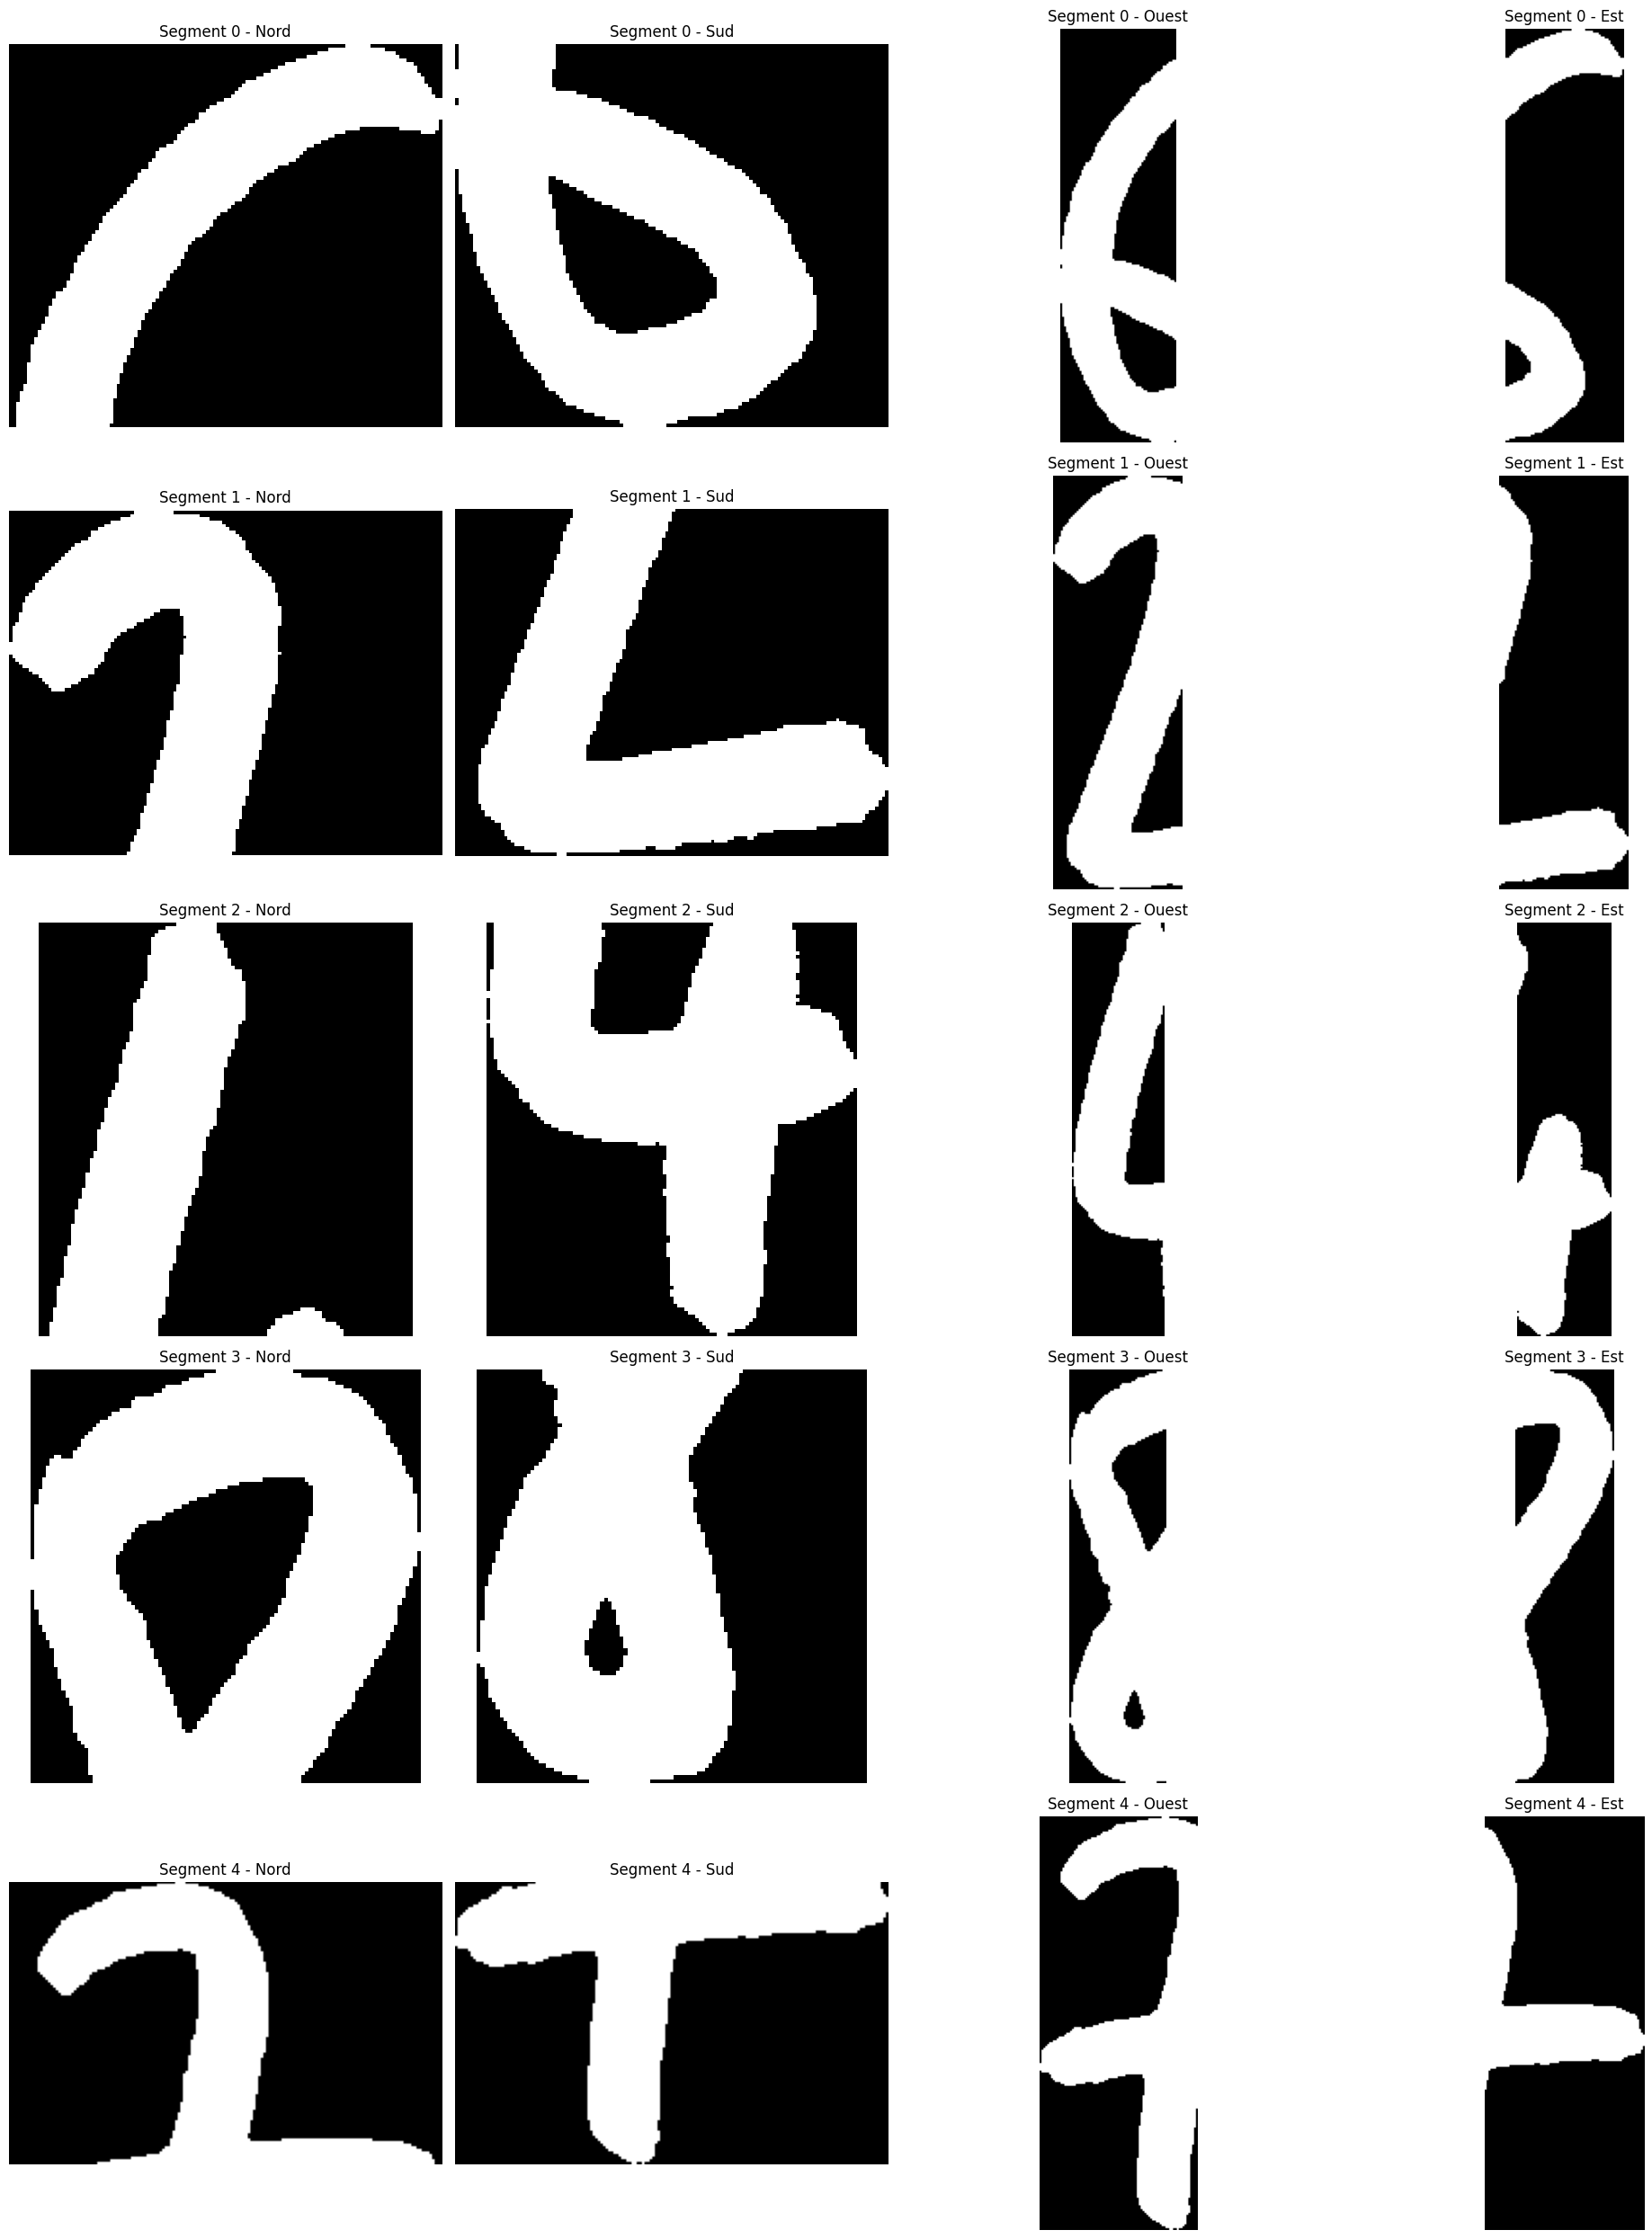

In [84]:
# Fonction pour sauvegarder et afficher les segments et leurs sous-segments
def save_segments(image, segments):
    """
    Sauvegarde et affiche chaque segment avec ses sous-segments.

    Args:
    - image (PIL.Image): L'image d'origine contenant les segments.
    - segments (list): Liste de tuples contenant les limites horizontales de chaque segment.

    Chaque segment est divisé en quatre sous-segments (nord, sud, ouest, est),
    qui sont affichés dans une disposition horizontale.
    """
    # Créer une figure de Matplotlib avec une taille adaptée au nombre de segments
    plt.figure(figsize=(20, 5 * len(segments)))

    # Parcourir tous les segments
    for i, (start, end) in enumerate(segments):
        # Extraire le segment de l'image d'origine
        segment = image.crop((start, 0, end, image.height))

        # Appliquer une opération de recadrage pour enlever les marges excessives
        trimmed_segment = trim_segment(segment)

        # Obtenir les dimensions du segment recadré
        width, height = trimmed_segment.size

        # Diviser le segment recadré en quatre sous-segments
        north_segment = trimmed_segment.crop((0, 0, width, height // 2))   # Nord
        south_segment = trimmed_segment.crop((0, height // 2, width, height))  # Sud
        west_segment = trimmed_segment.crop((0, 0, width // 2, height))   # Ouest
        east_segment = trimmed_segment.crop((width // 2, 0, width, height))   # Est

        # Afficher chaque sous-segment dans une disposition de grille
        plt.subplot(len(segments), 4, i * 4 + 1)
        plt.imshow(north_segment, cmap='gray')
        plt.title(f"Segment {i} - Nord")
        plt.axis('off')

        plt.subplot(len(segments), 4, i * 4 + 2)
        plt.imshow(south_segment, cmap='gray')
        plt.title(f"Segment {i} - Sud")
        plt.axis('off')

        plt.subplot(len(segments), 4, i * 4 + 3)
        plt.imshow(west_segment, cmap='gray')
        plt.title(f"Segment {i} - Ouest")
        plt.axis('off')

        plt.subplot(len(segments), 4, i * 4 + 4)
        plt.imshow(east_segment, cmap='gray')
        plt.title(f"Segment {i} - Est")
        plt.axis('off')

    # Ajuster automatiquement la disposition des sous-graphiques pour éviter le chevauchement
    plt.tight_layout()
    # Afficher la figure contenant tous les segments et sous-segments
    plt.show()

# Vérifier si le script est exécuté en tant que programme principal
if __name__ == "__main__":
    main()


# **Création d'un algorithme d'apprentissage automatique pour la reconnaissance de caractères (chiffres) sur une image**

# Nous allons utiliser l'algorithme KNN (k-Nearest Neighbors, ou k-plus proches voisins) qui est une méthode de classification simple et intuitive utilisée en apprentissage automatique.
*Pour entrainer notre modèle KNN, nous allons utiliser des images d'entrainement contenant chacune un chiffre et chaque image sera associer à son étiquette (le chiffre qu'elle représente).*



In [86]:

# Prétraitement de l'image
def preprocess_image(image_path):
    """
    Charge une image depuis le chemin spécifié, la convertit en niveaux de gris
    et applique une binarisation pour obtenir une image binaire.
    """
    # Lire l'image depuis le chemin spécifié
    image = cv2.imread(image_path)

    # Convertir l'image en niveaux de gris
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Appliquer une binarisation pour obtenir une image binaire (pixels blancs pour le chiffre, noirs pour le fond)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Retourner l'image binaire
    return binary

# Segmentation de l'image
def segment_image(binary_image):
    """
    Segmente l'image binaire en trouvant les colonnes continues contenant des pixels blancs.
    Retourne les positions horizontales des segments.
    """
    width, height = binary_image.size  # Obtenir la largeur et la hauteur de l'image
    pixels = binary_image.load()  # Charger les pixels de l'image

    segments = []

    # Initialiser le début du segment
    start = None

    for x in range(width):  # Parcourir chaque colonne de l'image
        column_has_foreground = False  # Initialiser l'indicateur de présence de pixels blancs
        for y in range(height):  # Parcourir chaque ligne de la colonne
            if pixels[x, y] == 255:  # Si le pixel est blanc (chiffre)
                column_has_foreground = True  # Marquer la colonne comme contenant des pixels blancs
                break  # Sortir de la boucle interne

        if column_has_foreground and start is None:  # Si une nouvelle colonne contenant des pixels blancs est trouvée
            start = x  # Début d'un nouveau segment
        elif not column_has_foreground and start is not None:
            segments.append((start, x))  # Ajouter le segment à la liste des segments
            start = None  # Réinitialiser le début du segment

    if start is not None:  # Si un segment est en cours à la fin de l'image
        segments.append((start, width))  # Ajouter le dernier segment

    return segments  # Retourner la liste des segments

def trim_segment(segment):
    """
    Recadre un segment d'image pour enlever les marges vides autour du chiffre.
    """
    width, height = segment.size  # Obtenir la largeur et la hauteur du segment
    pixels = segment.load()  # Charger les pixels du segment

    top, bottom, left, right = height, 0, width, 0  # Initialiser les marges

    for y in range(height):  # Parcourir chaque ligne du segment
        for x in range(width):  # Parcourir chaque colonne du segment
            if pixels[x, y] == 255:  # Si le pixel est blanc (chiffre)
                if y < top:
                    top = y  # Mettre à jour la marge supérieure
                if y > bottom:
                    bottom = y  # Mettre à jour la marge inférieure
                if x < left:
                    left = x  # Mettre à jour la marge gauche
                if x > right:
                    right = x  # Mettre à jour la marge droite

    return segment.crop((left, top, right+1, bottom+1))  # Recadrer et retourner le segment

# Extraction des cavités dans les quatre directions
def extract_cavities(segment):
    """
    Extrait les cavités (zones blanches) dans les directions nord, sud, est et ouest
    et retourne le nombre de pixels blancs dans chaque direction.
    """

     # Extraire les segment nord, sud, est et ouest
    north_segment = segment.crop((0, 0, segment.width, segment.height // 2))
    south_segment = segment.crop((0, segment.height // 2, segment.width, segment.height))
    west_segment = segment.crop((0, 0, segment.width // 2, segment.height))
    east_segment = segment.crop((segment.width // 2, 0, segment.width, segment.height))

    # Compter les pixels blancs dans chaque segment (nord, sud, est et ouest)
    cavities_north = np.sum(north_segment) // 255
    cavities_south = np.sum(south_segment) // 255
    cavities_east = np.sum(east_segment) // 255
    cavities_west = np.sum(west_segment) // 255

    return cavities_north, cavities_south, cavities_east, cavities_west  # Retourner les cavités

# Extraction des caractéristiques
def extract_features(segment):
    """
    Extrait les caractéristiques d'un segment d'image, incluant une version redimensionnée de l'image
    et les cavités dans les quatre directions.
    """
    # Redimensionner l'image à 20x20 pixels et aplatir en un vecteur
    resized = np.array(segment.resize((20, 20))).flatten()

    # Extraire les cavités
    cavities_north, cavities_south, cavities_east, cavities_west = extract_cavities(segment)

    # Combiner les caractéristiques en un seul vecteur
    features = np.append(resized, [cavities_north, cavities_south, cavities_east, cavities_west])
    return features  # Retourner les caractéristiques

# Entraînement du modèle KNN
def train_knn(X, y):
    """
    Entraîne un modèle KNN sur les données fournies.
    """

    # Créer un classificateur KNN avec 5 voisins et pondération par distance
    knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

    # Entraîner le modèle KNN sur les données d'entraînement
    knn.fit(X, y)

    return knn

# Charger les données d'entraînement
def load_data(image_paths, labels):
    """
    Charge et prétraite les images d'entraînement, extrait les caractéristiques
    et retourne les caractéristiques et les étiquettes sous forme de tableaux.
    """
    X = []  # Initialiser la liste des caractéristiques
    y = []  # Initialiser la liste des étiquettes

    # Parcourir les chemins d'images et les étiquettes correspondantes
    for image_path, label in zip(image_paths, labels):
        binary_image = preprocess_image(image_path)
        segments = segment_image(Image.fromarray(binary_image))
        for start, end in segments:
            segment = Image.fromarray(binary_image).crop((start, 0, end, binary_image.shape[0]))
            trimmed_segment = trim_segment(segment)
            features = extract_features(trimmed_segment)
            X.append(features)  # Ajouter les caractéristiques à la liste
            y.append(label)  # Ajouter l'étiquette à la liste
    return np.array(X), np.array(y)  # Convertir les listes en tableaux numpy et les retourner

# Prédiction sur une nouvelle image
def predict_image(image_path, knn, label_encoder):
    """
    Prétraite et segmente une nouvelle image, extrait les caractéristiques des segments
    et retourne les prédictions du modèle KNN.
    """
    binary_image = preprocess_image(image_path)
    segments = segment_image(Image.fromarray(binary_image))
    predictions = []  # Initialiser la liste des prédictions
    for start, end in segments:
        segment = Image.fromarray(binary_image).crop((start, 0, end, binary_image.shape[0]))
        trimmed_segment = trim_segment(segment)

        # Extraire les caractéristiques et les aplatir pour la prédiction
        features = extract_features(trimmed_segment).reshape(1, -1)

        # Prédire le chiffre à partir des caractéristiques
        prediction = knn.predict(features)

        # Ajouter la prédiction décodée à la liste
        predictions.append(label_encoder.inverse_transform(prediction)[0])
    return predictions

# Spécifiez les chemins des images d'entraînement et leurs étiquettes correspondantes
image_paths = [
    'img0.jpg', 'img00.jpg', 'img1.jpg', 'img11.jpg', 'img2.jpg', 'img22.jpg',
    'img3.jpg', 'img33.jpg', 'img4.jpg', 'img44.jpg', 'img5.jpg', 'img55.jpg',
    'img6.jpg', 'img66.jpg', 'img7.jpg', 'img77.jpg', 'img8.jpg', 'img88.jpg',
    'img9.jpg', 'img99.jpg','imagesV2/img0.jpg', 'imagesV2/img00.jpg', 'imagesV2/img1.jpg',
    'imagesV2/img11.jpg', 'imagesV2/img111.jpg', 'imagesV2/img2.jpg', 'imagesV2/img22.jpg',
    'img3.jpg', 'img33.jpg', 'img4.jpg', 'img44.jpg', 'img5.jpg', 'img55.jpg', 'imagesV2/img6.jpg',
    'imagesV2/img66.jpg', 'imagesV2/img666.jpg', 'imagesV2/img7.jpg', 'imagesV2/img77.jpg',
    'imagesV2/img8.jpg', 'imagesV2/img88.jpg', 'imagesV2/img9.jpg', 'imagesV2/img99.jpg',
    'imagesV2/img999.jpg', '2.png', '4.png', '6.png', '7.png', '8.png'
]

# Spécifier les étiquettes correspondantes aux chemins des images
labels = [
    '0', '0', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5',
    '6', '6', '7', '7', '8', '8', '9', '9', '0', '0', '1', '1', '1', '2', '2',
    '3', '3', '4', '4', '5', '5', '6', '6', '6', '7', '7', '8', '8', '9', '9', '9', '2', '4', '6', '7', '8'
]

# Charger et prétraiter les images, extraire les caractéristiques et les étiquettes
X, y = load_data(image_paths, labels)

# Encoder les labels et les etiquettes
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Diviser les données en ensembles d'entraînement et de test
# Diviser les données en 80% entraînement et 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Entraîner le modèle KNN sur les données d'entraînement
knn = train_knn(X_train, y_train)

# Évaluer le modèle
y_pred = knn.predict(X_test)  # Prédire les étiquettes pour les données de test
print(f'Exactitude du modèle: {accuracy_score(y_test, y_pred)}')  # Calculer et afficher l'exactitude du modèle

# Prédiction sur une nouvelle image (téléchargez une nouvelle image pour prédiction)
new_image_path = 'code0.tif'

# Prétraiter et segmenter la nouvelle image, extraire les caractéristiques des segments et prédire les chiffres
predictions = predict_image(new_image_path, knn, label_encoder)
print(f'Prédictions des chiffres sur l\'image: {predictions}')


Exactitude du modèle: 0.5
Prédictions des chiffres sur l'image: ['6', '2', '4', '8', '7']
